In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Union
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('Data Limpia.csv')
#renombramos las columnas a Fecha y Cantidad de Prescripciones
df.columns = ['Fecha', 'Cantidad de Prescripciones']

In [3]:
df.head(5)

,Fecha,Cantidad de Prescripciones
0,1991-07-01,3.52659
1,1991-08-01,3.18089
2,1991-09-01,3.25222
3,1991-10-01,3.61100
4,1991-11-01,3.56587


In [4]:
df.tail(5)

,Fecha,Cantidad de Prescripciones
199,2008-01-01,21.65429
200,2008-03-01,18.26495
201,2008-04-01,23.10768
202,2008-05-01,22.91251
203,2008-06-01,19.43174


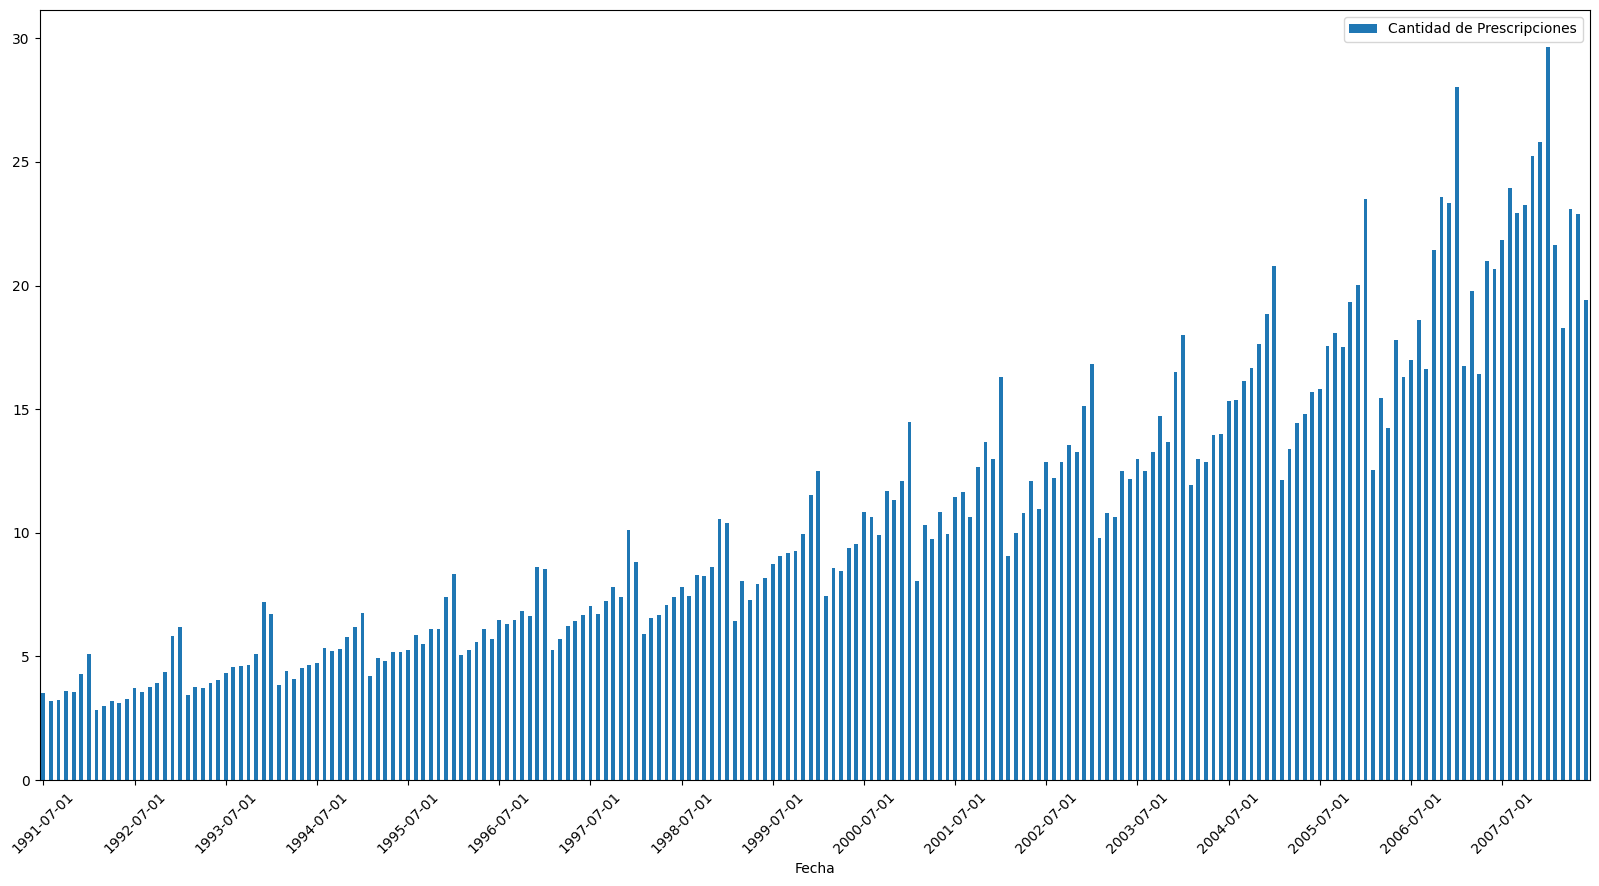

In [5]:
#Gráficamos la distribución de los datos con barras utilizando ambas columnas
df.plot.bar(x='Fecha', y='Cantidad de Prescripciones', rot=45, figsize=(20,10))
x_ticks = plt.gca().get_xticks()
plt.gca().set_xticks(x_ticks[::12])
plt.show()

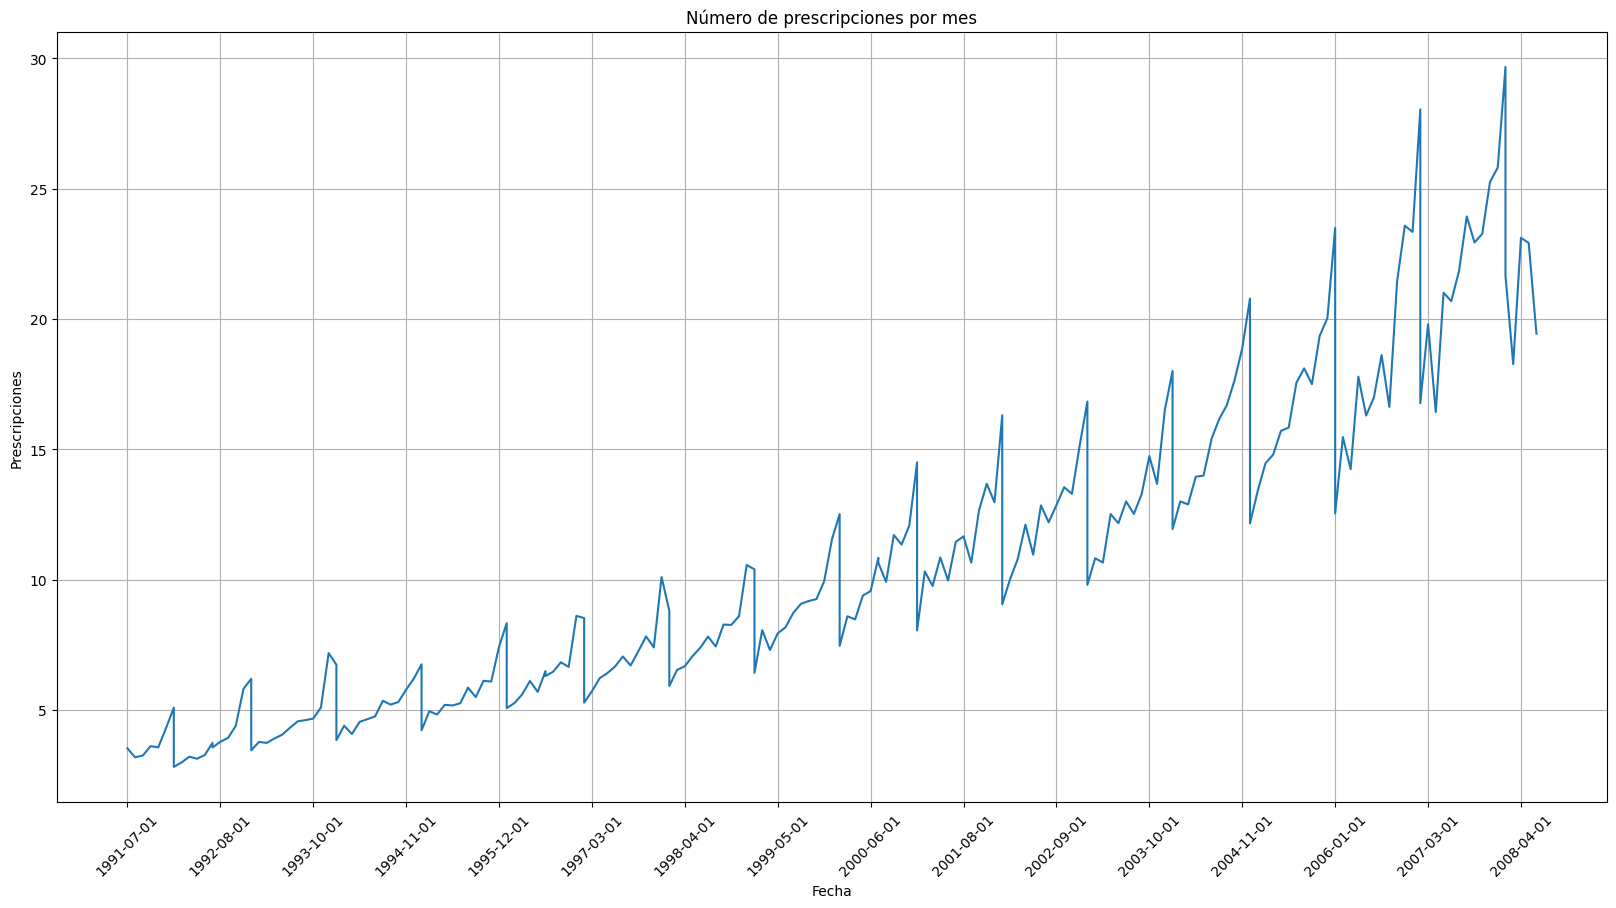

In [6]:
#Utilizamos otro gráfico ya que claramente vemos una tendencia pero no podemos ver los datos con claridad.
#utilizamos un subplot
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df['Fecha'], df['Cantidad de Prescripciones'])
ax.set(xlabel='Fecha', ylabel='Prescripciones', title='Número de prescripciones por mes')
ax.grid()
x_ticks = plt.gca().get_xticks()
plt.xticks(rotation=45)
plt.gca().set_xticks(x_ticks[::12])
plt.show()

Observamos que los datos tienen una tendencia estacional, que aumenta con los años. Esta es la principal razón para utilizar SARIMA por sobre ARIMA más adelante ya que el primero es el que toma en consideración la estacionalidad en las series de tiempo (después de todo, SARIMA se desglosa como Seasonal AutoRegressive Integrated Moving Average model).

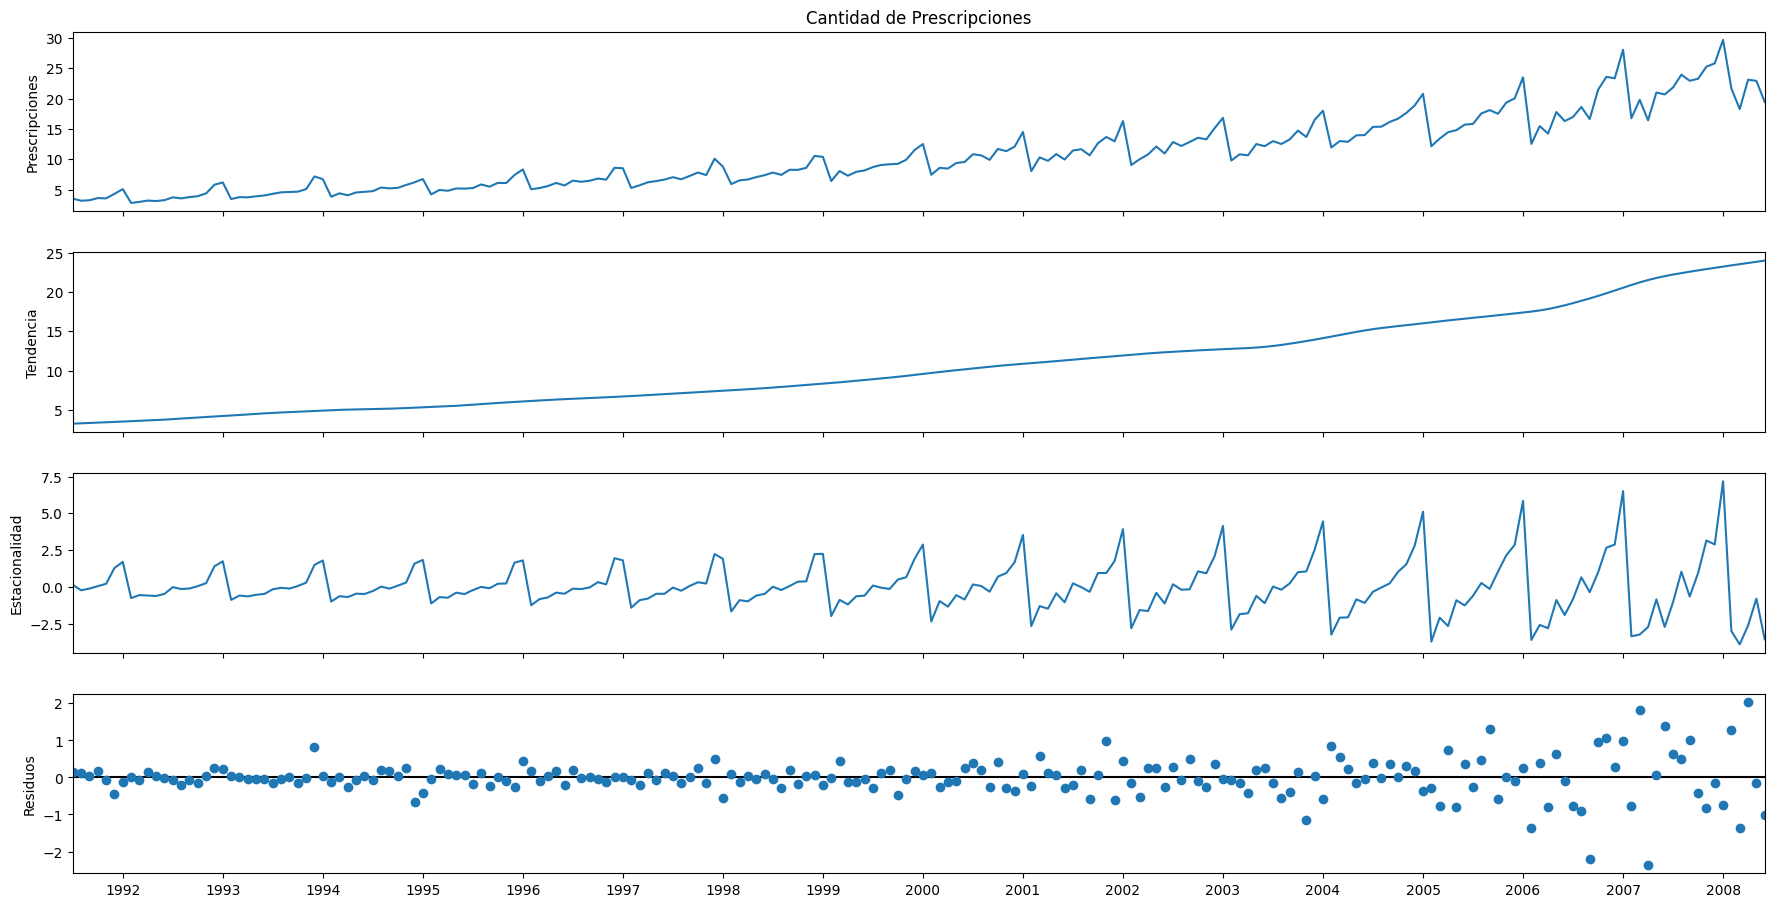

In [7]:
#Utilizaremos el paquete STL de statsmodels para observar las componentes de la serie de tiempo
stl = STL(df['Cantidad de Prescripciones'], period=12)   #periodo de 12 meses
res = stl.fit()
fig = res.plot()

#cambiamos los nombres de las leyendas de cada uno de los graficos
fig.axes[0].set_ylabel('Prescripciones')
fig.axes[1].set_ylabel('Tendencia')
fig.axes[2].set_ylabel('Estacionalidad')
fig.axes[3].set_ylabel('Residuos')
#tamaño de la figura
fig.set_figwidth(20)
fig.set_figheight(10)

#Configurar el eje X con fechas solo por años dentro de la columna Date
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

plt.show()

De lo anterior podemos observar 3 tipos de gráficas:
- La tendencia nos muestra el aumento gradual a lo largo de los años de cantidad de prescripciones.
- La estacionalidad nos muestra patrones repetitivos en los datos a lo largo de un año entre 1991 y 2008.
- Finalmente, el Residuo nos muestra lo errático que se va volviendo el pronóstico, el residuo nos indica la diferencia entre los valores reales y pronosticados a través de la tendencia y la estacionalidad.

Ahora queremos desarrollar el modelo, para ello, debemos empezar por ver que nuestra data presentada no tenga tendencia, sea estacional y no tenga autocorrelación entre sus datos, aplicamos de esta forma el método ADF comprobarlo. ADF nos ayuda a comprobar si es que existe tendencia y estacionalidad en la serie de tiempo.

In [8]:
#Función para probar la estacionaridad de la serie de tiempo
ADF = adfuller(df['Cantidad de Prescripciones'])
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: 3.145190
p-value: 1.000000


Ambos valores nos indican que nuestra data no es estacionaria y que existe una tendencia en los datos, ADF utiliza hipótesis para comprobar ambos dos, si esque un p-value menor a 0.05 y el ADF es un número negativo alto, se puede rechazar lo que llamamos *hipótesis nula* y confirmar que se trata de una serie de tiempo estacional y sin tendencia.

Aquí aplicamos un método de transformación para que la serie de tiempo sea estacionaria, utilizando la diferenciación, para ello solo aplicamos la función diff de numpy, que ira tomando la diferencia en los pares de datos y creando una nueva serie de tiempo, esperando que esta última si sea estacionaria.

In [9]:
Diff = np.diff(df['Cantidad de Prescripciones'],1)
ADF = adfuller(Diff)
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -2.495174
p-value: 0.116653


Los valores cambian para mejor, tomando en consideración que esperamos que el p-value disminuyera y que ADFS tomará valor negativo, sin embargo, aun no cumple lo suficientes requisitos como para ser totalmente estacionaria, por lo que haremos el tratamiento nuevamente.

Para el siguiente tratamiento tomaremos n=12 utilizando la diferenciación ya realizada, esto lo hacemos ya que la data es obtenida de forma mensual, teniendo así 12 meses en el año.

In [10]:
Season_Diff = np.diff(df['Cantidad de Prescripciones'],12)
ADF = adfuller(Season_Diff)
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -18.779673
p-value: 0.000000


Ahora podemos confirmar que nuestra serie de tiempo es estacionaria luego de realizar 1 diferenciación, y 1 diferenciación estacional (d=1 y D=1)

Para el entrenamiento del modelo no podemos ocupar el clásico train_test_split, esto porque es imperativo que las series de tiempo sean trabajadas en orden, el TTS toma porcentajes aleatorios de la muestra como train y test, pero para casos de este proyecto, se debe tomar un entrenamiento con cierto porcentaje de la data desde su valor inicial hasta un valor arbitrario, de acuerdo a lo que sea pertinente al modelo.

Tenemos data de 204 meses, por lo que utilizaremos 156 meses para el entrenamiento y los ultimos 4 años para realizar las pruebas.

In [11]:
train = df['Cantidad de Prescripciones'][:156]
test = df['Cantidad de Prescripciones'][156:]

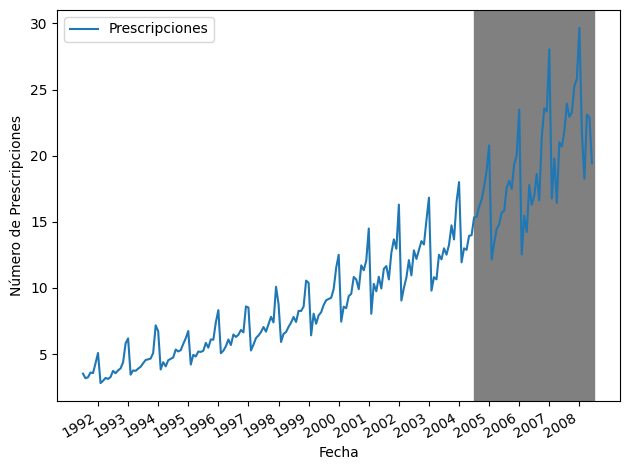

In [12]:
fig, ax = plt.subplots()

ax.plot(df['Cantidad de Prescripciones'], label='Prescripciones')
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de Prescripciones')
ax.axvspan(156, 204, color='grey')
fig.autofmt_xdate()

plt.legend()
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.tight_layout()

La sección en gris es el grupo de entramiento utilizado para el test.

Una vez definidas las muestras de entrenamiento y prueba, procedemos a desarrollar el modelo. Como se mencionó inicialmente, el modelo a utilizar es SARIMA, la razón para ocupar este por sobre ARIMA es que nuestra serie de tiempo presenta patrones estacionales, siendo SARIMA una extensión de ARIMA que toma en cuenta estos patrones. 

Hay que tomar en cuenta que SARIMA es un caso especial de SARIMAX, la mayor cualidad de este último es que toma en consideración variables exógenas, siendo esta cualquiera característica externa que afecte a la serie de tiempo, para casos de este proyecto, solo tomamos en consideración la cantidad de prescripciones realizadas en un mes, no hay factores externos que influyan.

Respecto al modelo elegido, SARIMA es un modelo que utiliza parámetros p, d, q, P, D, Q o bien SARIMA(p,d,q)(P,D,Q)m, para su modelación se seguirá la estructura de un SARIMAX (dado que es un caso especial), por lo que primero hay que empezar encontrar los valores de parámetros que optimicen el SARIMAX, conocemos ya 3 de ellos, siendo estos d, D y m, como 1, 1 y 12 respectivamente (estos valores de d y D son los que transforman nuestra serie de tiempo en estacionaria).

Con SARIMA(p,1,q)(P,1,Q)12 solo queda terminar de optimizar para encontrar valores para los parámetros faltantes que minimicen el AIC (Akaike's information criterion), este criterio nos ayuda a seleccionar el mejor modelo estadistico entre varios modelos presentados.



**Optimización y Modelamiento**

In [13]:
#Modelo de optimización SARIMAX
def OptSarimax(endog: Union[pd.Series,list], exog: Union[pd.Series,list], order_list: list, d: int, D: int, s:int):
    Resultados = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, exog, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s), simple_differencing=False)
            model_fit = model.fit(disp=False)
        except:
            continue
        Resultados.append([order, model_fit.aic])

    Resultados_df = pd.DataFrame(Resultados)
    Resultados_df.columns = ['Orden', 'AIC']
    Resultados_df = Resultados_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return Resultados_df

Creamos una lista para testear los valores de los parámetros.

In [14]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

d=1   #diferenciación
D=1   #diferenciación estacional
s=12  #periodo de la estacionalidad

In [15]:
#Optimización del modelo SARIMAX
#Resultados_SARIMA = OptSarimax(train, None, order_list, d, D, s)
#Resultados_SARIMA

Obtenemos 625 combinaciones diferentes para encontrar los parámetros adecuados.

De nuevo, ¿Para qué queriamos estos valores? estos son los valores de los parámetros para los cuales se minimiza el AIC, en el orden (p,q,P,Q), como observamos en el DataFrame, estos ya estan ordenados en orden ascendente con respecto a su AIC, por lo que los valores que minimizan mejor el AIC son (2, 3, 0, 1).

Ahora tenemos todos los valores para los parámetros del mejor modelo SARIMA (según la minimización del AIC), con esto por fin podemos modelar completamente el modelo.

SARIMA(p,d,q)(P,D,Q)m = SARIMA(2,1,3)(0,1,1)12

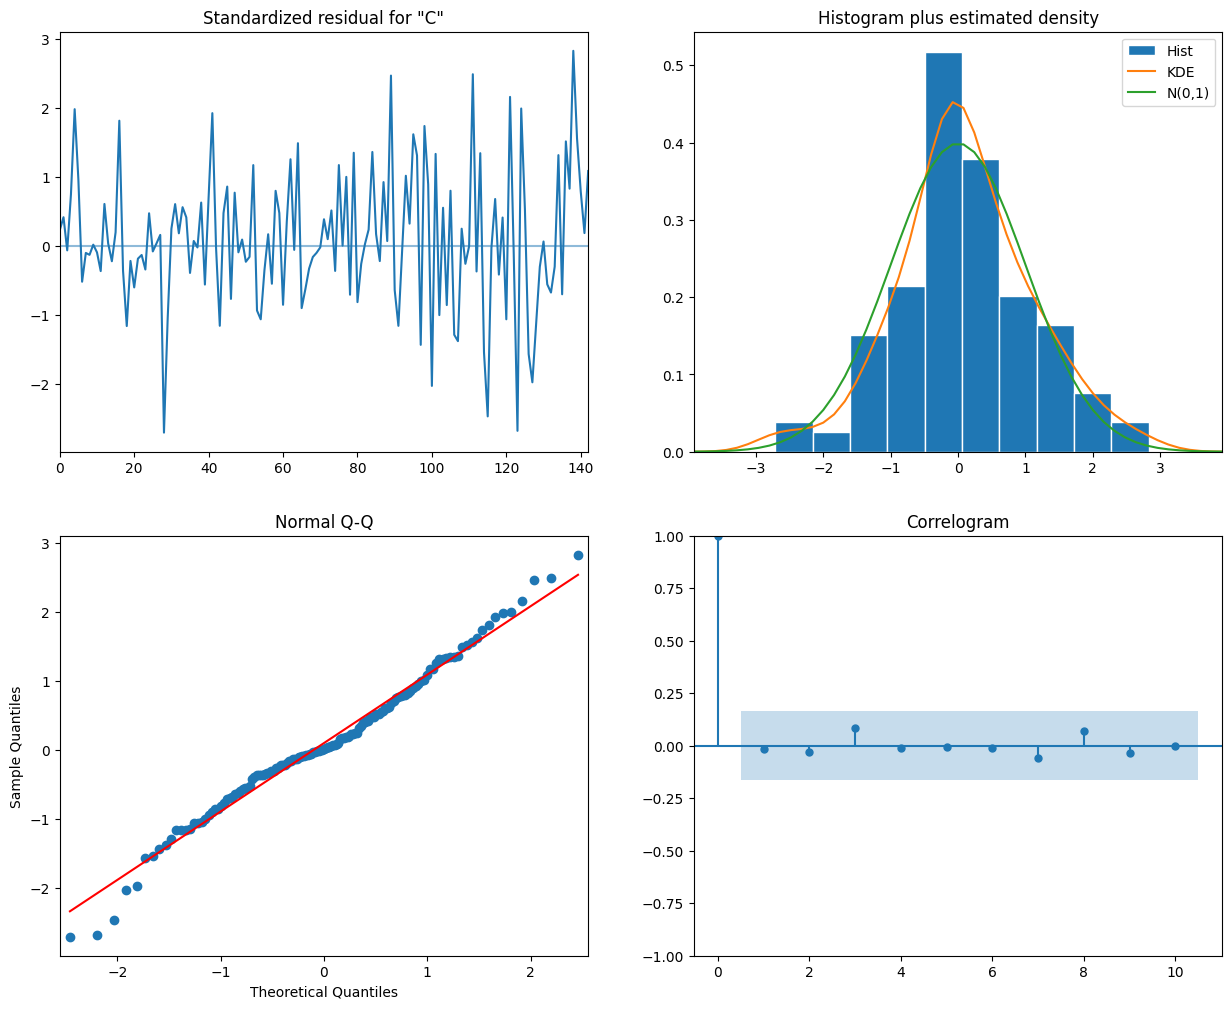

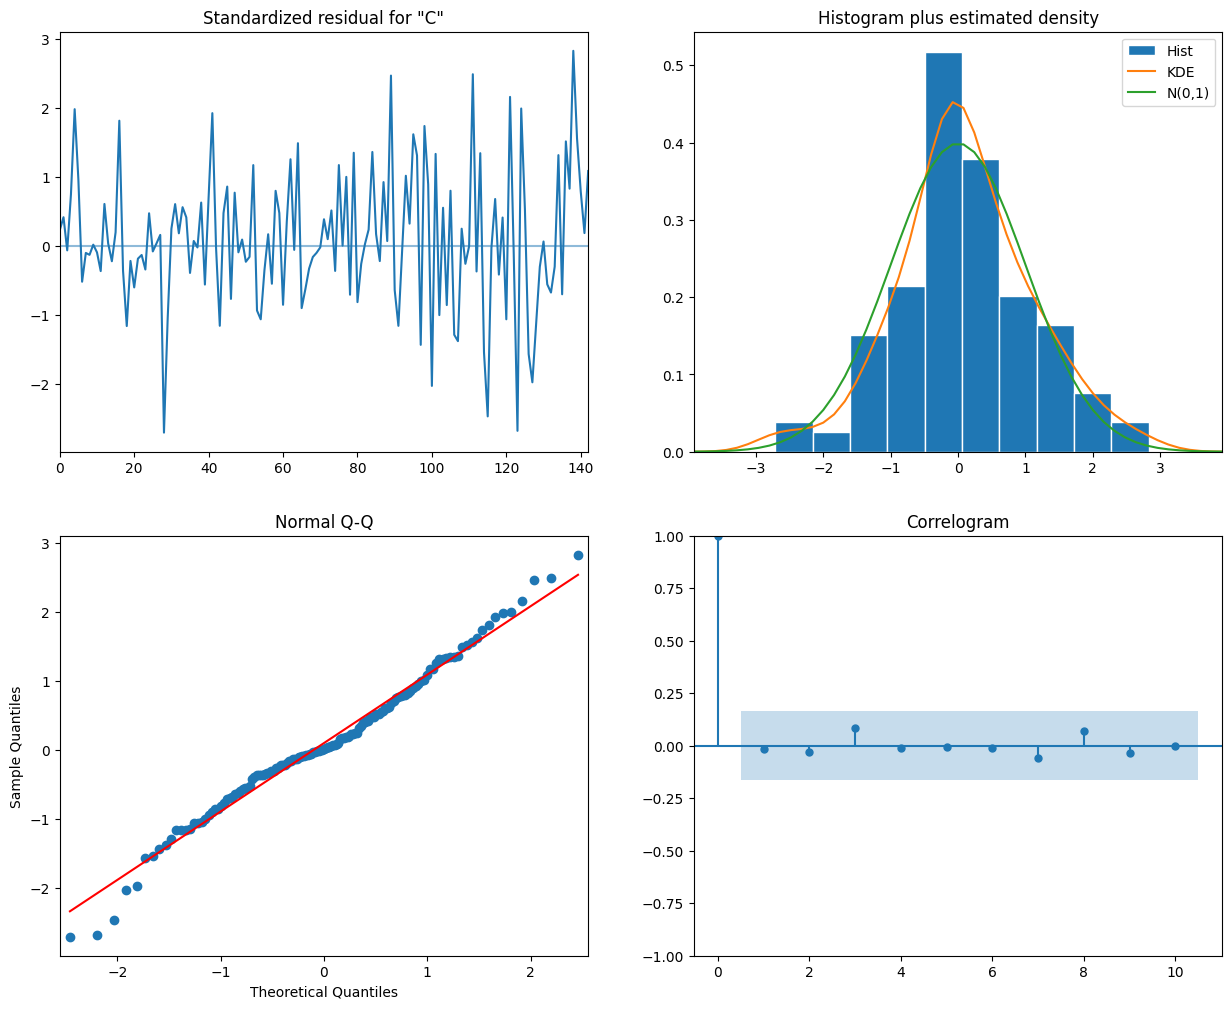

In [16]:
#Modelo SARIMA
SARIMA = SARIMAX(train, order=(2, 1, 3), seasonal_order=(0, 1, 1, 12), simple_differencing=False)
SARIMA_fit = SARIMA.fit(disp=False)
SARIMA_fit.plot_diagnostics(figsize=(15, 12))

¿Que observamos en estos gráficos?

- Superior izquierdo nos indica la tendencia, no hay, la varianza pareciera mantenerse constante, por lo podemos asumir que tenemos un modelo estacionario.
- Superior derecho muestra la distribución que tiene el residuo siendo similar a una Normal.
- Inferior izquierdo muestra la relación lineal que existe entre los valores de muestra y los teoricos dados por el modelo.
- Inferior derecho indica la correlación existente entre las variables, tampoco hay, estos pequeños valores se asimilan a lo que llamamos anteriormente como ruido blanco.

**Ahora procedemos con el pronostico**

Hay que tener un poco de cuidado, utilizaremos 4 años de data para testear y así pronosticar 6 meses, pero no queremos caer en aun así sigue siendo muy pequeña la muestra, por lo que además del modelo SARIMA, se utilizará también un modelo estacional como referencia, que utilizará los 12 últimos meses de la data como muestra para pronosticar los siguientes 12 meses. ¿Por qué 12 meses? Primero trabajaremos nuestros modelos con get_predict, y esto predecira para los valores en nuestra muestra de prueba, luego de desarrollar los modelos y medir sus rendimientos utilizaremos get_forecast para lograr nuestro objetivo.

Este proceso de comparación se lleva a cabo mediante el método Rolling Forecast, tomando como parámetros:
- El Dataframe trabajado.
- Tamaño de la muestra de entrenamiento.
- Horizonte, que corresponde al tamaño de la muestra de prueba.
- Ventana, que corresponde a cuantos puntos queremos pronosticar.
- Método, cuál es el modelo que se utilizará en el pronóstico.

De esta forma podemos crear una comparación entre las predicciones de varios modelos simultáneamente.

In [17]:
#Creacion de pronostico a partir de ambos modelos.
def Rolling_Forecast(df:pd.DataFrame, 
            Strain: int,         #tamaño del conjunto de entrenamiento   
            horizon: int,        #tamaño del conjunto de prueba
            window: int,         #cuanto queremos pronosticar (en meses)
            method: str) -> list:
    
    total = Strain + horizon
    iex = Strain

    if method == 'Seasonal':
        pred_Seasonal = []
        for i in tqdm_notebook(range(Strain, total, window)):
            Season = df['Cantidad de Prescripciones'][i-window:i].values
            pred_Seasonal.extend(Season)

        return pred_Seasonal

    elif method == 'SARIMA':
        pred_SARIMA = []
        for i in tqdm_notebook(range(Strain, total, window)):
            modelo = SARIMAX(train, order=(2, 1, 3), seasonal_order=(0, 1, 1, 12), simple_differencing=False)
            modelo_SARIMA = modelo.fit(disp=False)
            Pred = modelo_SARIMA.get_prediction(start=0, end=i+window-1)
            Out = Pred.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(Out)

        return pred_SARIMA


Ahora procedemos a asignar valores a las constantes:
- Strain = 156
- Horizon = 48
- Window = 12

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

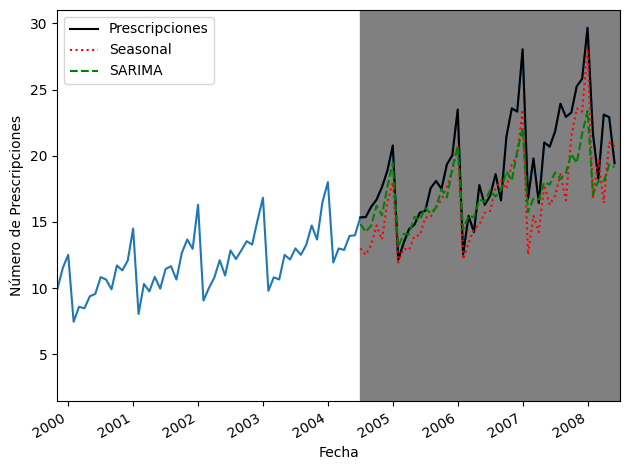

In [18]:
Predicciones = df[156:]
Predicciones['Seasonal'] = Rolling_Forecast(df, 156, 48, 12, 'Seasonal')
Predicciones['SARIMA'] = Rolling_Forecast(df, 156, 48, 12, 'SARIMA')

fig, ax = plt.subplots()

ax.plot(df['Cantidad de Prescripciones'])
ax.plot(Predicciones['Cantidad de Prescripciones'],'b-',color='black', label='Prescripciones')
ax.plot(Predicciones['Seasonal'], 'r:', color='red', label='Seasonal')
ax.plot(Predicciones['SARIMA'], 'b--', color='green', label='SARIMA')

ax.set_xlabel('Fecha')
ax.set_ylabel('Número de Prescripciones')
ax.axvspan(156, 204, color='grey')
fig.autofmt_xdate()

plt.legend()
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(100, 204)
plt.tight_layout()

Podemos observar que poco a poco SARIMA se aleja de los valores reales, y esto quizas es debido a que ocupamos pocos datos para el entrenamiento, asique en lugar de dejar 4 años para prueba, dejaremos solo 3 y el resto lo dejaremos para entrenamiento, para esto debemos realizar los mismo pasos que hemos seguido hasta hora desde cero:

- Optimizar para encontrar parámetros.
- Modelar con los parámetros encontrados.
- Pronosticar.

In [19]:
#Optimización del modelo SARIMAX con una muestra de 3 años en la prueba
train2 = df['Cantidad de Prescripciones'][:168]
test2 = df['Cantidad de Prescripciones'][168:]

def OptSarimax(endog: Union[pd.Series,list], exog: Union[pd.Series,list], order_list: list, d: int, D: int, s:int):
    Resultados = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, exog, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s), simple_differencing=False)
            model_fit = model.fit(disp=False)
        except:
            continue
        Resultados.append([order, model_fit.aic])

    Resultados_df = pd.DataFrame(Resultados)
    Resultados_df.columns = ['Orden', 'AIC']
    Resultados_df = Resultados_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return Resultados_df

ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

d=1
D=1
s=12

#Resultados_SARIMA2 = OptSarimax(train2, None, order_list, d, D, s)
#Resultados_SARIMA2

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

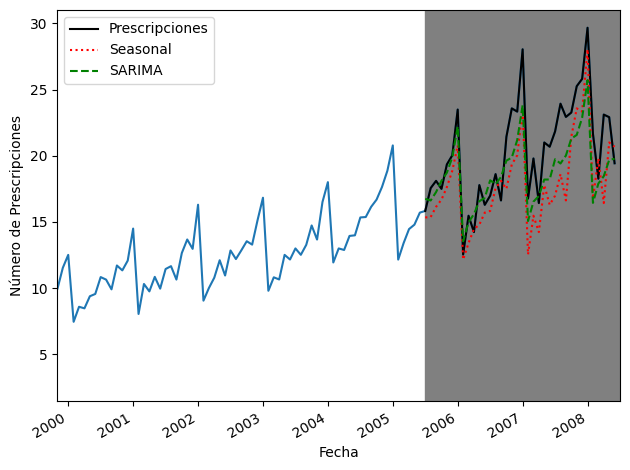

In [20]:
#Modelamos y pronosticamos con los datos de 1992 a 2008
def Rolling_Forecast(df:pd.DataFrame, 
            Strain: int,         #tamaño del conjunto de entrenamiento   
            horizon: int,        #tamaño del conjunto de prueba
            window: int,         #cuanto queremos pronosticar (en meses)
            method: str) -> list:
    
    total = Strain + horizon
    iex = Strain

    if method == 'Seasonal':
        pred_Seasonal = []
        for i in tqdm_notebook(range(Strain, total, window)):
            Season = df['Cantidad de Prescripciones'][i-window:i].values
            pred_Seasonal.extend(Season)

        return pred_Seasonal

    elif method == 'SARIMA':
        pred_SARIMA = []
        for i in tqdm_notebook(range(Strain, total, window)):
            modelo = SARIMAX(train2, order=(3, 1, 1), seasonal_order=(1, 1, 3, 12), simple_differencing=False)
            modelo_SARIMA = modelo.fit(disp=False)
            Pred = modelo_SARIMA.get_prediction(start=0, end=i+window-1)
            Out = Pred.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(Out)

        return pred_SARIMA

Predicciones_2 = df[168:]
Predicciones_2['Seasonal'] = Rolling_Forecast(df, 168, 36, 12, 'Seasonal')
Predicciones_2['SARIMA'] = Rolling_Forecast(df, 168, 36, 12, 'SARIMA')

fig, ax = plt.subplots()
ax.plot(df['Cantidad de Prescripciones'])
ax.plot(Predicciones_2['Cantidad de Prescripciones'],'b-',color='black', label='Prescripciones')
ax.plot(Predicciones_2['Seasonal'], 'r:', color='red', label='Seasonal')
ax.plot(Predicciones_2['SARIMA'], 'b--', color='green', label='SARIMA')
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de Prescripciones')
ax.axvspan(168, 204, color='grey')
fig.autofmt_xdate()
plt.legend()
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(100, 204)
plt.tight_layout()

Con esto tenemos una comparación entre dos SARIMA y una baseline, por lo que ahora la siguiente pregunta es, ¿cuál es mejor?

**Evaluación de los pronósticos**

Aquí evaluaremos la calidad de los modelos a través de la métrica MAPE (Mean Absolute Percentage Error) el cual es el indicador de desempeño para modelos de pronóstico en series de tiempo. Este evalúa los modelos midiendo el error porcentual promedio entre los valores pronosticados y los valores reales.


In [21]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE_Seasonal   = mape(Predicciones['Cantidad de Prescripciones'], Predicciones['Seasonal'])
MAPE_SARIMA_T48 = mape(Predicciones['Cantidad de Prescripciones'], Predicciones['SARIMA'])     #(2,3,0,1)
MAPE_SARIMA_T36 = mape(Predicciones_2['Cantidad de Prescripciones'], Predicciones_2['SARIMA']) #(3,1,1,3)

print('MAPE Seasonal: ', MAPE_Seasonal, 'MAPE SARIMA T48: ', MAPE_SARIMA_T48, 'MAPE SARIMA T36: ', MAPE_SARIMA_T36)

MAPE Seasonal:  12.516910170639195 MAPE SARIMA T48:  10.066710186919687 MAPE SARIMA T36:  9.327247699923797


Los MAPE obtenidos:
- Seasonal               = 22.58%
- SARIMA(2,1,3)(0,1,1)12 = 10.07%
- SARIMA(3,1,1)(1,1,3)12 = 9.33%

El modelo desarrollado utilizando la predicción a través de la última temporada tiene un porcentaje de error promedio más alto que ambos SARIMA, y en general ambos SARIMA tiene un rendimiento muy bueno, particularmente SARIMA(2,1,3)(0,1,1) mejor que el anterior con una diferencia no muy significativa entre ellos a pesar de tener año de data de entrenamiento más que SARIMA(3,1,1)(1,1,3).

Podemos intentar reducir aún más el horizonte para entrenar, pero estaremos arriesgando un overfitting en el modelo.

**Volviendo al objetivo**

Finalmente nos enfocamos en el objetivo inicial, pronosticar los siguientes 6 meses de prescripciones anti-diabeticas en Australia, para ello debemos retocar nuestro modelo.
Antes estábamos prediciendo en el modelo para las muestras utilizando la función get_predict, sin embargo, ahora queremos pronosticar 6 meses que desconocemos, por lo que utilizamos get_forecast.

Get_forecast recibe la cantidad de pasos que queremos pronosticar a partir de nuestro modelo y nos entrega estos valores.

In [22]:
forecast_sarima = []
modelo = SARIMAX(train2, order=(3, 1, 1), seasonal_order=(1, 1, 3, 12), simple_differencing=False)
modelo_SARIMA = modelo.fit(disp=False)
Pred = modelo_SARIMA.get_forecast(6)
Out = Pred.predicted_mean
forecast_sarima.extend(Out)

Colocando una ventana igual a 6 obtenemos el pronostico de los meses que desconocemos.

**Conclusión**

- Luego de modelar SARIMA obtenemos un error porcentual de 9.33% de que las cantidades pronosticadas difieran de las cantidades reales que vayan a ser descritas en lo que queda del 2008.

- Mientras mas bajo sea el valor del MAPE, mayor es la calidad de pronostico del modelo, y un MAPE de 9.33% es un porcentaje aceptable de error para la cantidad de data que estamos trabajando, sin embargo, esto podría mejorarse si esque tuvieramos una mayor muestra de datos, recordemos que tenemos muestras mensuales entre los años 1991 y 2008.


Con esto finalmente obtenemos el pronostico de la cantidad aproximada de medicinas anti-diabeticas que podrian ser prescritas en Australia. 

In [23]:
df = pd.DataFrame({
    'Fecha': ['2008-08-01', '2008-09-01', '2008-10-01', '2008-11-01', '2008-12-01', '2009-01-01'],
    'Cantidades pronosticadas de prescripciones': forecast_sarima
})
df

,Fecha,Cantidades pronosticadas de prescripciones
0,2008-08-01,16.745846
1,2008-09-01,16.619355
2,2008-10-01,17.255328
3,2008-11-01,18.107526
4,2008-12-01,18.722224
5,2009-01-01,19.885873
